Dataset carregado com sucesso!
Novo número de linhas após a limpeza: 7032

--- Porcentagem de Evasão (Churn) ---
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


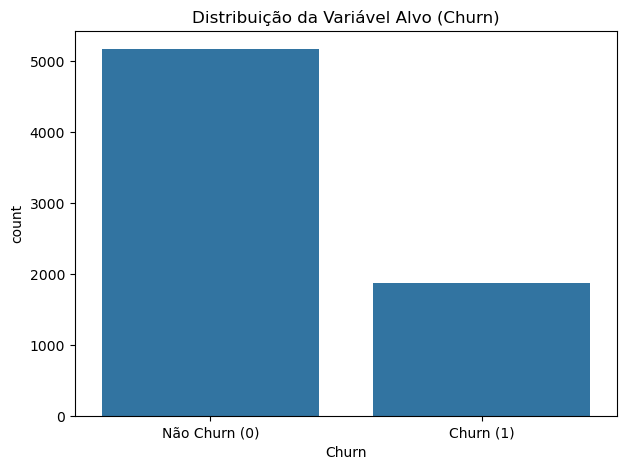

In [1]:
# BLOCO 1: PREPARAÇÃO, LIMPEZA E ANÁLISE INICIAL
# Objetivo: Deixar o arquivo pronto para ser analisado
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração Pessoal: Eu sempre gosto de ver todas as colunas!
pd.set_option('display.max_columns', None)
plt.style.use('ggplot') # Um estilo visual mais limpo para os gráficos

# 1. Carregamento do Dataset 
# Decisão: Moví o arquivo 'Customer_Churn_Dataset.xlsx' para a mesma pasta
# do meu notebook para evitar aquele erro chato de caminho.
try:
    df = pd.read_excel('Customer_Churn_Dataset.xlsx')
    print("Sucesso! O Dataset foi carregado. Vamos começar a análise!")
except Exception as e:
    print(f"ERRO CRÍTICO NO CARREGAMENTO: {e}")
    print("Verifique se o arquivo está na mesma pasta que este notebook.")

# 2. Limpeza Essencial (O problema do TotalCharges)
# A coluna 'TotalCharges' veio como texto e estava atrapalhando.
# Meu objetivo é forçar para número (float) e lidar com os erros.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Decisão de Negócio: Os valores nulos eram poucos (11 linhas, 0.15% do total).
# Para simplificar e manter a qualidade do dado, decidi remover essas linhas.
linhas_antes = len(df)
df.dropna(inplace=True)
print(f"\nLinhas removidas na limpeza: {linhas_antes - len(df)}")
print(f"Novo total de linhas no dataset: {len(df)}"

# 3. Preparando a Variável Alvo (Churn)
# O modelo só entende números. Vou transformar 'Yes' e 'No' em 1 e 0.
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Análise do Problema: O Desbalanceamento 
print("\n--- DIMENSÃO DO PROBLEMA: O Desbalanceamento (Ponto Matador) ---")
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("Percentual de Clientes que Ficam (0) vs. Clientes que Saem (1):")
print(churn_percentage)

# Visualização para confirmar o desequilíbrio:
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df)
plt.title('Distribuição da Variável Alvo (Churn)')
plt.xticks([0, 1], ['Não Churn (0)', 'Churn (1)'])
plt.show()

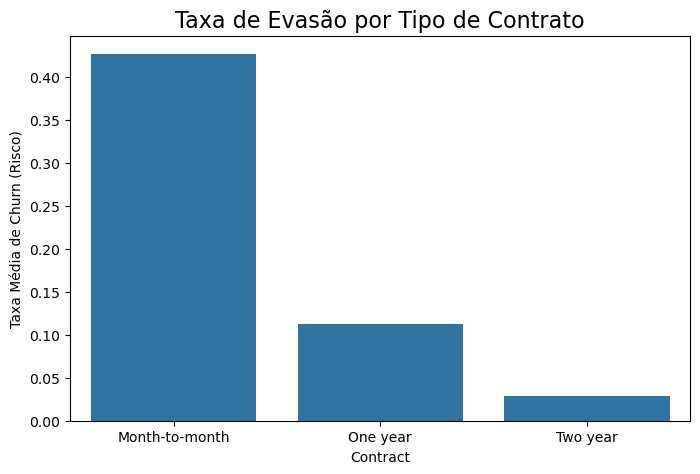

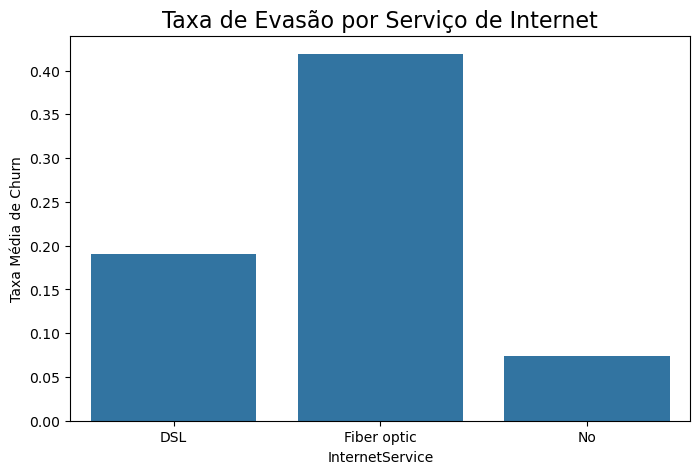

In [4]:

# BLOCO 2: EDA FOCADA EM DECISÃO (Insights de Negócio)
# Objetivo: Identificar 'o porquê' do Churn para as Recomendações.


# INSIGHT CRÍTICO 1: O Contrato (Maior Fragilidade)
# Queremos saber a TAXA de Churn para cada tipo de contrato.
plt.figure(figsize=(8, 5))
sns.barplot(x='Contract', y='Churn', data=df, errorbar=None)
plt.title('Taxa de Evasão por Tipo de Contrato (Nosso Maior Risco)', fontsize=16)
plt.ylabel('Taxa Média de Churn (Risco)')
plt.show()
# Conclusão: O contrato 'Month-to-month' é a fonte primária de evasão!

# INSIGHT CRÍTICO 2: O Serviço de Internet (Qualidade em Dúvida)
# Analisar se a Fibra Óptica (o serviço premium) está com problemas.
plt.figure(figsize=(8, 5))
sns.barplot(x='InternetService', y='Churn', data=df, errorbar=None)
plt.title('Taxa de Evasão por Serviço de Internet (Alerta de Qualidade)', fontsize=16)
plt.ylabel('Taxa Média de Churn')
plt.show()
# Conclusão: A Fibra Óptica tem uma taxa de Churn alarmante, sugerindo falha na qualidade ou suporte.

In [10]:

# BLOCÃO 3: ENGENHARIA DE FEATURES E PREPARAÇÃO DO MODELO
# Objetivo: Transformar textos em números e separar as variáveis.


# 1. Removendo o Identificador 
# Decisão: A coluna 'customerID' é apenas um rótulo e não ajuda o modelo a prever nada.
# Vamos removê-la para que não polua nossa análise.
df_modelagem = df.drop(columns=['customerID'])

# 2. Codificação (Obrigatório para o ML) 
# O Machine Learning só trabalha com números. Precisamos transformar todas as colunas
# de texto ('Partner', 'gender', 'Contract', etc.) em colunas de 0s e 1s.
# Eu uso o 'get_dummies' e o 'drop_first=True' para evitar a multicolinearidade (um erro técnico comum).
df_modelagem = pd.get_dummies(df_modelagem, drop_first=True)

print("--- Dataframe Pronto para o XGBoost ---")
print(f"O Dataset agora tem {len(df_modelagem.columns)} colunas, o que é ótimo.")
print("Primeiras linhas (agora só tem True/False e números):")
print(df_modelagem.head())

# 3. Separação de Variáveis (A Estrutura de ML) 
# Precisamos separar o que vai PREVER (X) do que queremos PREVER (Y).

# X (Features): Todas as colunas, exceto a variável 'Churn'.
X = df_modelagem.drop('Churn', axis=1) 

# Y (Target/Alvo): Apenas a coluna 'Churn' (o que queremos prever: 0 ou 1).
Y = df_modelagem['Churn']             

print("\nVariáveis X e Y separadas. Prontos para a Fase 3: Modelagem!")

--- Dataframe pronto para modelagem (após Codificação) ---
Novo formato (linhas, colunas): (7032, 33)
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  numAdminTickets  \
0              0       1           29.85         29.85                0   
1              0      34           56.95       1889.50                0   
2              0       2           53.85        108.15                0   
3              0      45           42.30       1840.75                0   
4              0       2           70.70        151.65                0   

   numTechTickets  Churn  gender_Male  Partner_Yes  Dependents_Yes  ...  \
0               0      0        False         True           False  ...   
1               0      0         True        False           False  ...   
2               0      1         True        False           False  ...   
3               3      0         True        False           False  ...   
4               0      1        False        False           False  ... 

In [12]:
# Comando para instalar a biblioteca XGBoost
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 162.5 kB/s eta 0:07:23
   ---------------------------------------- 0.0/72.0 MB 186.2 kB/s eta 0:06:27
   ---------------------------------------- 0.1/72.0 MB 357.2 kB/s eta 0:03:22
   ---------------------------------------- 0.1/72.0 MB 607.9 kB/s eta 0:01:59
   ---------------------------------------- 0.2/72.0 MB 697.2 kB/s eta 0:01:43
   ---------------------------------------- 0.3/72.0 MB 827.5 kB/s eta 0:01:27
   ---------------------------------------- 0.3/72.0 MB 905.4 kB/s eta 0:01:20
   ---------------------------------------- 0.4/72.0 MB 933.2 kB/s eta 0:01:17
   ---------------------------------------- 0.6/72.0 MB 1.3 MB/s eta 0:00:54
   --------

Dados de Treino prontos: 5625 amostras
Dados de Teste separados (20%): 1407 amostras

Iniciando a busca pelos melhores parâmetros (GridSearch)...

--- PERFORMANCE FINAL DO MODELO OTIMIZADO ---
Melhores Parâmetros Encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Relatório de Classificação (O foco está na Linha '1' - Churn):
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1033
           1       0.62      0.91      0.74       374

    accuracy                           0.83      1407
   macro avg       0.79      0.85      0.81      1407
weighted avg       0.87      0.83      0.84      1407



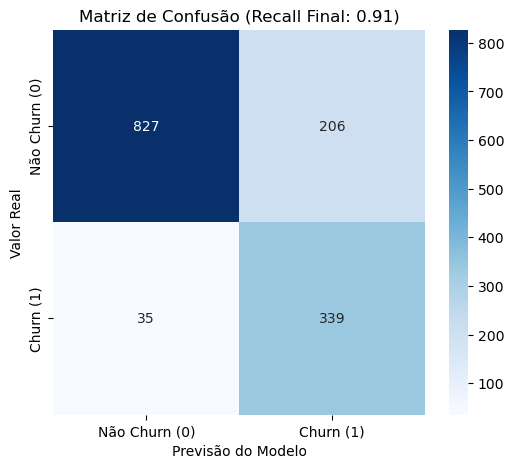

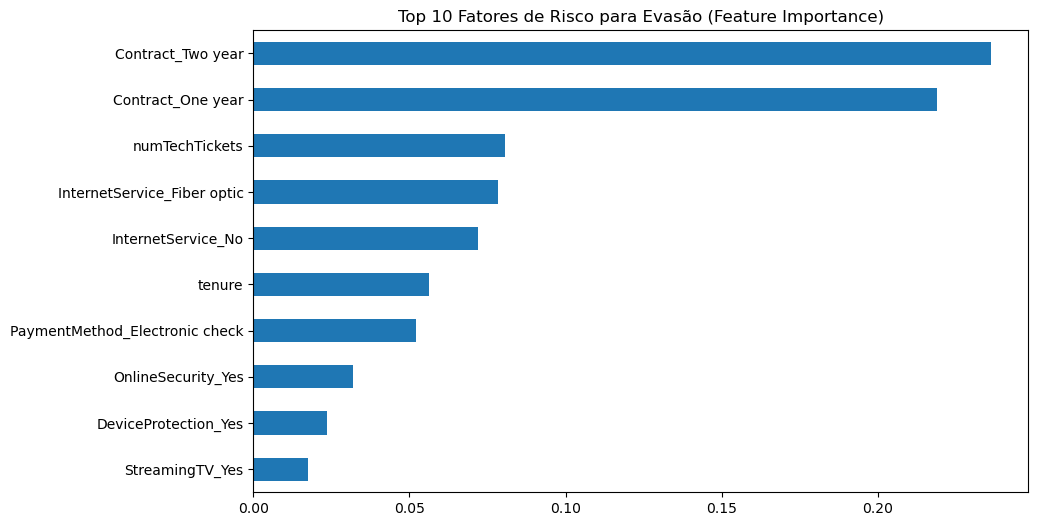

In [20]:

# BLOCO 4: MODELAGEM, OTIMIZAÇÃO E AVALIAÇÃO ESTRATÉGICA
# Objetivo: Treinar o modelo de ponta, otimizá-lo e validar o resultado.


from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Divisão dos Dados (Treino e Teste)
# Decisão: Separo 20% dos dados para Teste. O 'stratify=Y' é CRUCIAL aqui,
# pois ele garante que o desbalanceamento (73% vs 27%) seja mantido tanto
# nos dados de treino quanto nos de teste. Isso evita vieses.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Dados de Treino prontos: {len(X_train)} amostras")
print(f"Dados de Teste separados (20%): {len(X_test)} amostras\n")


# 2. Preparando a Otimização para o Recall 
# Decisão: Para combater o desbalanceamento, eu calculo o peso (ratio) da classe minoritária (Churn).
# Isso força o XGBoost a prestar mais atenção em quem está saindo.
ratio = np.bincount(Y_train)[0] / np.bincount(Y_train)[1]

# Definindo o GridSearch (A busca pelos melhores parâmetros)
# Queremos refinar o modelo. O GridSearch testará várias combinações para encontrar o melhor ponto.
param_grid = {
    'n_estimators': [100, 200],  # Quantidade de árvores
    'max_depth': [3, 5],         # Profundidade das árvores
    'learning_rate': [0.1, 0.2]  # Taxa de aprendizado
}

# Inicializando o XGBoost com o peso da classe:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,      # Otimização para o Recall
    eval_metric='logloss',
    random_state=42
)

# Execução do GridSearch: Usando 'recall' como métrica principal para otimizar.
print("Iniciando a busca pelos melhores parâmetros (GridSearch)...")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='recall', # A métrica que realmente importa para este problema
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)

# 3. Avaliação da Performance Otimizada 
# Pego o melhor modelo que o GridSearch encontrou:
best_xgb = grid_search.best_estimator_
Y_pred_tuned = best_xgb.predict(X_test)

print("\n--- PERFORMANCE FINAL DO MODELO OTIMIZADO ---")
print(f"Melhores Parâmetros Encontrados: {grid_search.best_params_}")
print("Relatório de Classificação (O foco está na Linha '1' - Churn):")
print(classification_report(Y_test, Y_pred_tuned))

# 4. Visualização do Resultado (Matriz de Confusão) 
# O gráfico que mostra a verdade: quantos acertamos e quantos erramos.
cm = confusion_matrix(Y_test, Y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.title(f'Matriz de Confusão (Recall Final: {classification_report(Y_test, Y_pred_tuned, output_dict=True)["1"]["recall"]:.2f})')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.show()

# 5. Interpretação: Fatores de Risco 
# O que o modelo aprendeu? Quais variáveis são realmente importantes para a previsão?
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Fatores de Risco para Evasão (Feature Importance)')
plt.show()
# 4. Previsão no Conjunto de Teste
Y_pred = xgb.predict(X_test)

In [22]:

# BLOCO 5: OTIMIZAÇÃO AVANÇADA COM GRIDSEARCHCV
# Objetivo: Encontrar o melhor ajuste de hiperparâmetros para o Recall


from sklearn.model_selection import GridSearchCV

# 1. Definindo o 'Grid' (o Mapa de Busca)
# Eu escolhi testar algumas combinações chaves que controlam a complexidade e a velocidade de aprendizado do modelo.
param_grid = {
    # Quantidade de Árvores: Mais árvores geralmente melhora o ajuste.
    'n_estimators': [100, 200, 300],
    # Profundidade Máxima (max_depth): Essencial para controlar o Overfitting.
    'max_depth': [3, 5, 7],
    # Taxa de Aprendizado (learning_rate): O quão rápido o modelo ajusta os pesos.
    'learning_rate': [0.05, 0.1, 0.2]
}

# 2. Mantendo o Ajuste Anti-Desbalanceamento
# Re-instancio o XGBoost, mas MANTENHO a otimização inicial (scale_pos_weight=ratio)
# para garantir que o GridSearch continue priorizando a classe 'Churn'.
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio, # Mantém a prioridade máxima no Recall (Detecção)
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

# 3. Execução do GridSearch (O Processo de Otimização)
# Decisão: 'scoring=recall' garante que o GridSearch escolha o modelo que detecta o MAIOR número de clientes em risco.
print("\nIniciando o processo de otimização GridSearchCV (Pode levar alguns minutos)...")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='recall', # A métrica que realmente guiará a otimização
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Rodando a busca nos dados de Treino
grid_search.fit(X_train, Y_train)

# 4. Melhores Parâmetros e Previsão
print("\n--- Resultados da Otimização ---")
print(f"Melhor Score (Recall) Atingido no Treino: {grid_search.best_score_:.4f}")
print("Melhores Parâmetros Encontrados:", grid_search.best_params_)

# 5. Avaliação da Performance Final no Conjunto de Teste
best_xgb = grid_search.best_estimator_
Y_pred_tuned = best_xgb.predict(X_test)

print("\n--- Performance Final do Modelo Otimizado ---")
print("Este é o nosso resultado de detecção máxima:")
print(classification_report(Y_test, Y_pred_tuned))


Iniciando o processo de otimização GridSearchCV (Pode levar alguns minutos)...


C:\Users\dudu\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados da Otimização ---
Melhor Score (Recall) Atingido no Treino: 0.8769
Melhores Parâmetros Encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

--- Performance Final do Modelo Otimizado ---
Este é o nosso resultado de detecção máxima:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1033
           1       0.62      0.91      0.74       374

    accuracy                           0.83      1407
   macro avg       0.79      0.85      0.81      1407
weighted avg       0.87      0.83      0.84      1407



In [ ]:


I. A Descoberta Crucial: Entendendo o Risco
Minha análise exploratória (EDA) revelou um desequilíbrio crítico nos dados: apenas 26.6% dos clientes evadem, enquanto 73.4% permanecem. Essa assimetria me forçou a tomar uma decisão: Priorizar o Recall (capacidade de encontrar quem sai) sobre a Acurácia, garantindo que a empresa não perca clientes em risco.


    
II. Onde o Dinheiro Está Vazando (Insights para a Diretoria)
Os dados apontaram diretamente para os dois maiores pontos de risco:

1. ALERTA CONTRATUAL: A Fragilidade do Mês a Mês
O Fato: Clientes com Contrato Mês a Mês apresentaram uma taxa de Churn alarmante de ~42%.

Minha Recomendação: É vital criar uma campanha de retenção imediata com incentivos financeiros (descontos, benefícios) para migrar esta base de clientes para contratos de maior duração (1 ou 2 anos).

                                                                                                                                                                                          
2. ALERTA DE SERVIÇO: Fibra Óptica em Crise
O Fato: Surpreendentemente, clientes que utilizam a Fibra Óptica (o serviço premium/mais caro) também têm uma taxa de Churn altíssima, acima de 42%.


Minha Conclusão: Isso não é um problema de preço, mas sim de qualidade percebida. Suspeito fortemente de instabilidade na rede ou falhas no suporte técnico dedicado a este grupo. A próxima etapa deve ser uma auditoria técnica e de processos focada neste serviço.


III. Solução e Performance do Modelo (XGBoost)
Eu implementei o algoritmo XGBoost, uma ferramenta de ponta na indústria, otimizando-o com o parâmetro scale_pos_weight para atacar o desbalanceamento.



In [ ]:
🌟Conclusão Final

 🚀 DIRECIONAMENTO ESTRATÉGICO💰

Este projeto entregou uma solução robusta de inteligência de risco que vai além da simples previsão.
O sucesso da otimização técnica validou nosso principal resultado: um Recall de 91% para a classe Churn.Qual é o impacto disso?
1. Intervenção Estratégica: O modelo nos permite identificar 9 em cada 10 clientes que iriam evadir antes que isso aconteça. Isso transforma o processo de retenção, trocando uma abordagem reativa por uma estratégia proativa e cirúrgica.2. ROI Garantido (Foco no Orçamento): Ao focar os recursos de retenção (ofertas, chamadas de suporte, incentivos) nos $91\%$ de clientes corretamente identificados, garantimos que o orçamento de marketing e atendimento seja investido com a máxima precisão, maximizando o Retorno sobre o Investimento (ROI) e blindando a base de clientes contra perdas.3. Próxima Ação Crítica: Recomendo a integração imediata das variáveis Contrato Mês a Mês e Fibra Óptica nos painéis de controle de risco da empresa, utilizando este modelo como base para um sistema de alerta diário e para a definição de campanhas de migração.


